In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [2]:
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
#alt.renderers.enable('colab')

  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-bm3hlc3y
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-bm3hlc3y
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for altair: filename=altair-4.2.0.dev0-py3-none-any.whl size=729978 sha256=d7b73693a1744610d8a43b34b81c2d2e0fe3b962b9d5f48d11718f9131f07b1e
  Stored in directory: /tmp/pip-ephem-wheel-cache-wnu_takc/wheels/06/13/e0/5bd72c969fe3954ee1561739e5c58e2ddfe5c10fcdffb12faa
Successfully built altair


DataTransformerRegistry.enable('default')

Now that we have done some EDA (exploratory data analysis), we will do some feature engineering using the variables that we looked at in the ETL notebook. We'll start as before but after we try some things out, we will use Apache Beam to run a pipeline

In [3]:
%%bigquery df
SELECT
  pov.Geographic_Area,
  pov.City,
  poverty_rate,
  percent_completed_hs
FROM
  police_brutality.PercentagePeopleBelowPovertyLevel AS pov
JOIN
  police_brutality.PercentOver25CompletedHighSchool AS high
ON
  pov.Geographic_Area=high.Geographic_Area
  AND pov.City=high.City

In [8]:
df.tail()

,Geographic_Area,City,poverty_rate,percent_completed_hs
29324,WY,East Thermopolis town,18.800,88.500
29325,WY,Encampment town,28.800,98.800
29326,WY,Lucerne CDP,0.900,80.400
29327,WY,Moose Wilson Road CDP,1.800,97.300
29328,WY,Riverside town,1.800,100.000


In [30]:
base_sql = """
CREATE TEMPORARY FUNCTION CLIP_LESS(x FLOAT64, a FLOAT64) AS (
  IF (x < a, a, x)
);
CREATE TEMPORARY FUNCTION CLIP_GT(x FLOAT64, b FLOAT64) AS (
  IF (x > b, b, x)
);
CREATE TEMPORARY FUNCTION CLIP(x FLOAT64, a FLOAT64, b FLOAT64) AS (
  CLIP_GT(CLIP_LESS(x, a), b)
);

WITH stats AS (
    SELECT
      MIN(poverty_rate) AS min_pov,
      IF(MAX(poverty_rate)<60, MAX(poverty_rate), 60) AS max_pov,
      AVG(IF(poverty_rate < 60, poverty_rate, 60)) AS avg_pov,
      STDDEV(IF(poverty_rate <60, poverty_rate, 60)) AS stddev_pov,
      APPROX_QUANTILES(IF(poverty_rate <60, poverty_rate, 60), 100)[OFFSET(1)] AS percentile_1,
      APPROX_QUANTILES(IF(poverty_rate <60, poverty_rate, 60), 100)[OFFSET(99)] AS percentile_99
    FROM
      police_brutality.PercentagePeopleBelowPovertyLevel 
),

scaling AS (
    SELECT
      IF(IFNULL(poverty_rate, -1) < 60, poverty_rate, 60) as poverty_rate,
      IFNULL(Median_Income, -1) as Median_Income,
      SAFE_DIVIDE(2*poverty_rate - 60 - min_pov, 60 - min_pov) AS minmax_scaled,
      CLIP( (poverty_rate - avg_pov)/(avg_pov/2.0), -1, 1 ) AS clipped,
      SAFE_DIVIDE(poverty_rate - avg_pov, stddev_pov) AS zscore,
      CLIP(poverty_rate, percentile_1, percentile_99) AS winsorized_1_99,
      SAFE_DIVIDE(2*CLIP(poverty_rate, percentile_1, percentile_99) - percentile_1 - percentile_99, percentile_99 - percentile_1) AS winsorized_scaled
    FROM
      police_brutality.combined_wo_killings, stats
)
"""

def scaled_stats(base_col):
    sql = base_sql + """
SELECT
   {0},
   AVG(Median_Income) AS avg_inc,
   COUNT(1) AS num_cities
FROM
   scaling
GROUP BY {0}
ORDER BY {0}
    """.format(base_col)
    from google.cloud import bigquery
    return bigquery.Client().query(sql).to_dataframe()

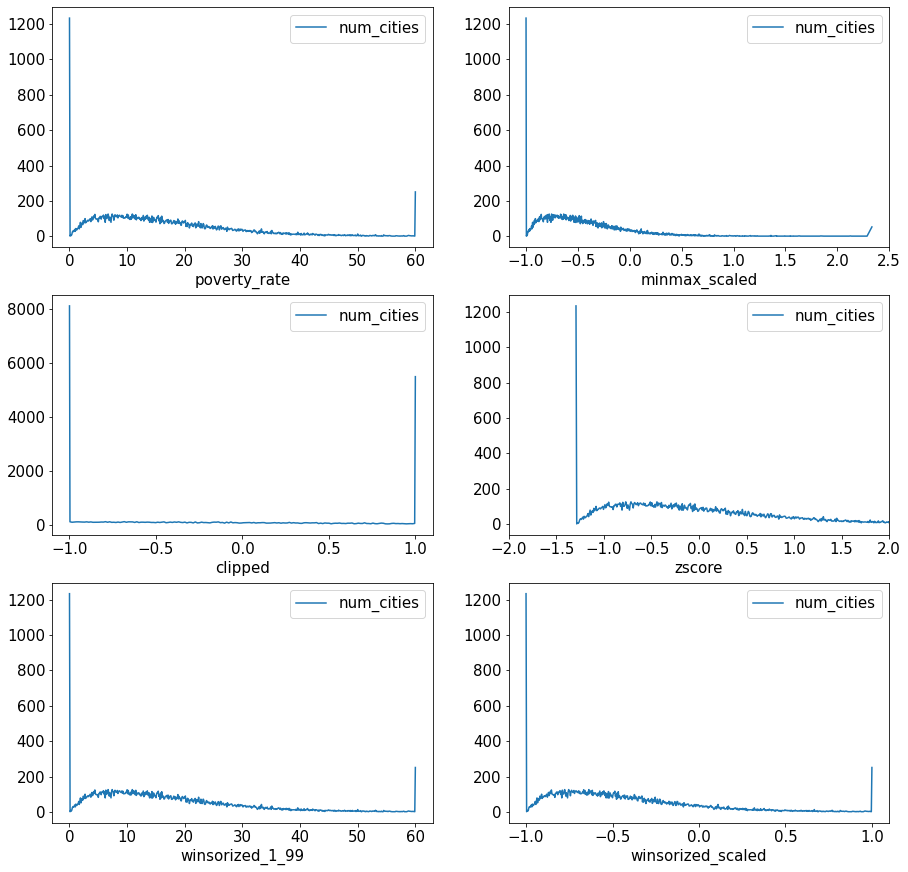

In [31]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(3, 2);
scaled_stats('poverty_rate').plot(x='poverty_rate', y='num_cities', ax=axs[0, 0]);
scaled_stats('minmax_scaled').plot(x='minmax_scaled', y='num_cities', ax=axs[0, 1]);
scaled_stats('clipped').plot(x='clipped', y='num_cities', ax=axs[1, 0]);
scaled_stats('zscore').plot(x='zscore', y='num_cities', ax=axs[1, 1], xlim=[-2, 2]);
scaled_stats('winsorized_1_99').plot(x='winsorized_1_99', y='num_cities', ax=axs[2, 0]);
scaled_stats('winsorized_scaled').plot(x='winsorized_scaled', y='num_cities', ax=axs[2, 1]);
fig.savefig('scaling.png')
#plt.close(fig)
plt.show()

Here we are scaling the povery rate, where we note that above 60% there is not enough data and thus we constrain the povery rate to not go above that.  The question then is, which scaling should we choose? Generally, when the curve looks like a normal or uniform distribution we have a good scaling.  In the case of neural networks, we should ensure that all features are between $-1$ and $1$, which is the case for the minimax, winsorized and the clipped scales but not for the zscore and wisorized-1_99 scales. The big problem we should notice here is that there's not a lot of data for each poverty level; Hence I will use bucketing. 

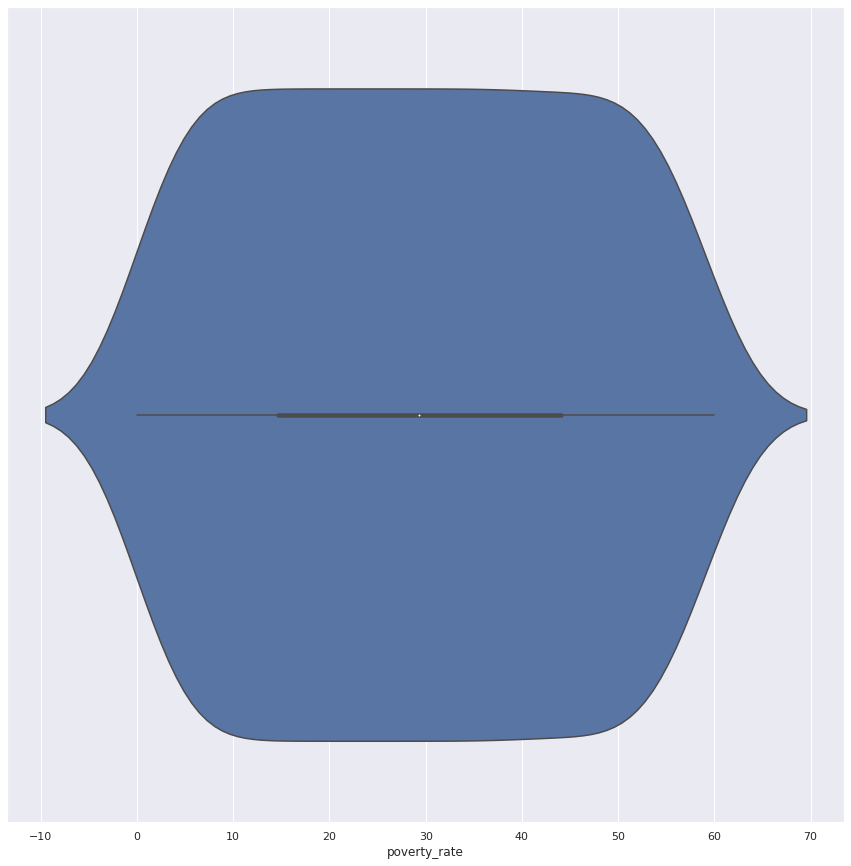

In [53]:
sns.set_style("whitegrid")
sns.set(font="DejaVu Sans")
ax = sns.violinplot(data=scaled_stats('poverty_rate'), x='poverty_rate', inner='box', orient='h')

The unscaled poverty rate looks quite symmetric now, after I clipped it at 60%.   Nevertheless, we will use bucketing with learned threasholds:

In [15]:
%%bigquery buckets
WITH
  percentile AS (
  SELECT
    APPROX_QUANTILES( share_hispanic, 30) AS hispanic,
    APPROX_QUANTILES( share_native_american, 30) AS native_american,
    APPROX_QUANTILES( share_asian, 30) AS asian,
    APPROX_QUANTILES(share_black, 30) AS black,
    APPROX_QUANTILES(share_white, 30) AS white,
    APPROX_QUANTILES(percent_completed_hs, 30) AS hs,
    APPROX_QUANTILES(Median_Income, 30) AS income,
    APPROX_QUANTILES(poverty_rate, 30) AS poverty
  FROM
    police_brutality.combined_wo_killings ),
  bucketized AS (
  SELECT
    state,
    City AS city,
    CAST(REPLACE(ML.BUCKETIZE( poverty_rate,
          poverty), 'bin_', '') AS int64) AS poverty,
    CAST(REPLACE(ML.BUCKETIZE( percent_completed_hs,
          hs), 'bin_', '') AS int64) AS completed_hs,
    CAST(REPLACE(ML.BUCKETIZE( Median_Income,
          income), 'bin_', '') AS int64) AS income,
    CAST(REPLACE(ML.BUCKETIZE( share_white,
          white), 'bin_', '') AS int64) AS white,
    CAST(REPLACE(ML.BUCKETIZE( share_black,
          black), 'bin_', '') AS int64) AS black,
    CAST(REPLACE(ML.BUCKETIZE( share_hispanic,
          hispanic), 'bin_', '') AS int64) AS hispanic,
    CAST(REPLACE(ML.BUCKETIZE( share_asian,
          asian ), 'bin_', '') AS int64) AS asian,
    CAST(REPLACE(ML.BUCKETIZE( share_native_american,
          native_american ), 'bin_', '') AS int64) AS native_american,
  FROM
    police_brutality.combined_wo_killings,
    percentile)
SELECT
  state, city,  
  ifnull(poverty, -1) as povery,
  ifnull(completed_hs, -1) as completed_hs,
  ifnull(income, -1) as income,
  ifnull(white, -1) as white,
  ifnull(black, -1) as black,
  ifnull(hispanic, -1) as hispanic,
  ifnull(asian, -1) as asian,
  ifnull(native_american, -1) as native_american,
FROM
  bucketized

In [16]:
buckets.head()

,state,city,povery,completed_hs,income,white,black,hispanic,asian,native_american
0,MN,Welcome city,23,15,11,31,3,15,2,2
1,PA,Walnuttown CDP,21,3,11,31,2,8,2,2
2,IL,Farmersville village,20,27,21,31,2,4,2,2
3,ND,Strasburg city,19,4,2,31,2,2,2,2
4,MN,Ivanhoe city,16,14,10,31,2,3,2,2


In [20]:
buckets.describe()

,povery,completed_hs,income,white,black,hispanic,asian,native_american
count,28018.000,28018.000,28018.000,28018.000,28018.000,28018.000,28018.000,28018.000
mean,15.462,16.440,16.027,16.583,10.701,14.695,7.770,6.826
std,8.672,8.765,9.005,8.759,7.264,8.459,5.525,4.674
min,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
25%,8.000,9.000,8.000,9.000,4.000,7.000,2.000,3.000
50%,15.000,16.000,16.000,17.000,10.000,15.000,6.000,5.000
75%,23.000,24.000,24.000,24.000,17.000,22.000,12.000,10.000
max,31.000,31.000,32.000,32.000,25.000,30.000,20.000,18.000


In [24]:
np.array(sorted(buckets['income'].unique()))

array([-1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

We give a special treatment to missing values and the assumptions will be important; I will give them their own category of -1 as missing values are assumed not to arise randomly. 

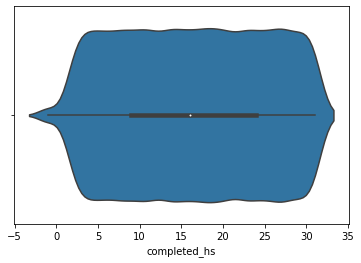

In [19]:
ax = sns.violinplot(data=buckets, x='completed_hs', inner='box', orient='h')

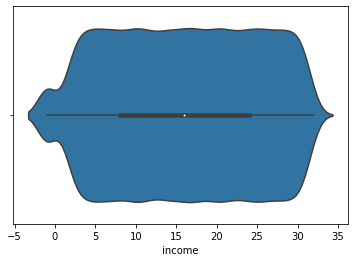

In [21]:
ax = sns.violinplot(data=buckets, x='income', inner='box', orient='h')

Now we can see very balanced features with $-1$ outliers for the missing value category. Now we want to look at correlations of these features:

In [35]:
base_sql = """
WITH
  percentile AS (
  SELECT
    APPROX_QUANTILES( share_hispanic, 30) AS hispanic,
    APPROX_QUANTILES( share_native_american, 30) AS native_american,
    APPROX_QUANTILES( share_asian, 30) AS asian,
    APPROX_QUANTILES(share_black, 30) AS black,
    APPROX_QUANTILES(share_white, 30) AS white,
    APPROX_QUANTILES(percent_completed_hs, 30) AS hs,
    APPROX_QUANTILES(Median_Income, 30) AS income,
    APPROX_QUANTILES(poverty_rate, 30) AS poverty
  FROM
    police_brutality.combined_wo_killings ),
  bucketized AS (
  SELECT
    state,
    City AS city,
    CAST(REPLACE(ML.BUCKETIZE( poverty_rate,
          poverty), 'bin_', '') AS int64) AS poverty,
    CAST(REPLACE(ML.BUCKETIZE( percent_completed_hs,
          hs), 'bin_', '') AS int64) AS completed_hs,
    CAST(REPLACE(ML.BUCKETIZE( Median_Income,
          income), 'bin_', '') AS int64) AS income,
    CAST(REPLACE(ML.BUCKETIZE( share_white,
          white), 'bin_', '') AS int64) AS white,
    CAST(REPLACE(ML.BUCKETIZE( share_black,
          black), 'bin_', '') AS int64) AS black,
    CAST(REPLACE(ML.BUCKETIZE( share_hispanic,
          hispanic), 'bin_', '') AS int64) AS hispanic,
    CAST(REPLACE(ML.BUCKETIZE( share_asian,
          asian ), 'bin_', '') AS int64) AS asian,
    CAST(REPLACE(ML.BUCKETIZE( share_native_american,
          native_american ), 'bin_', '') AS int64) AS native_american,
  FROM
    police_brutality.combined_wo_killings,
    percentile),
  features AS (
  SELECT
    state, city,  
    ifnull(poverty, -1) as poverty,
    ifnull(completed_hs, -1) as completed_hs,
    ifnull(income, -1) as income,
    ifnull(white, -1) as white,
    ifnull(black, -1) as black,
    ifnull(hispanic, -1) as hispanic,
    ifnull(asian, -1) as asian,
    ifnull(native_american, -1) as native_american,
  FROM
    bucketized)
"""

def corr_stats(base_col):
    sql = base_sql + """
SELECT
   {0},
   AVG(completed_hs) AS avg_hs,
  STDDEV(completed_hs) AS std_hs,
  AVG(white) AS avg_white,
  STDDEV(white) as std_white,
  AVG(black) AS avg_black,
  STDDEV(black) as std_black,
  AVG(hispanic) AS avg_hispanic,
  STDDEV(hispanic) as std_hispanic,
  AVG(asian) AS avg_asian,
  STDDEV(asian) as std_asian,
  AVG(native_american) AS avg_native_american,
  STDDEV(native_american) as std_native_american,
FROM
  features
GROUP BY {0}
ORDER BY {0}
    """.format(base_col)
    from google.cloud import bigquery
    return bigquery.Client().query(sql).to_dataframe()

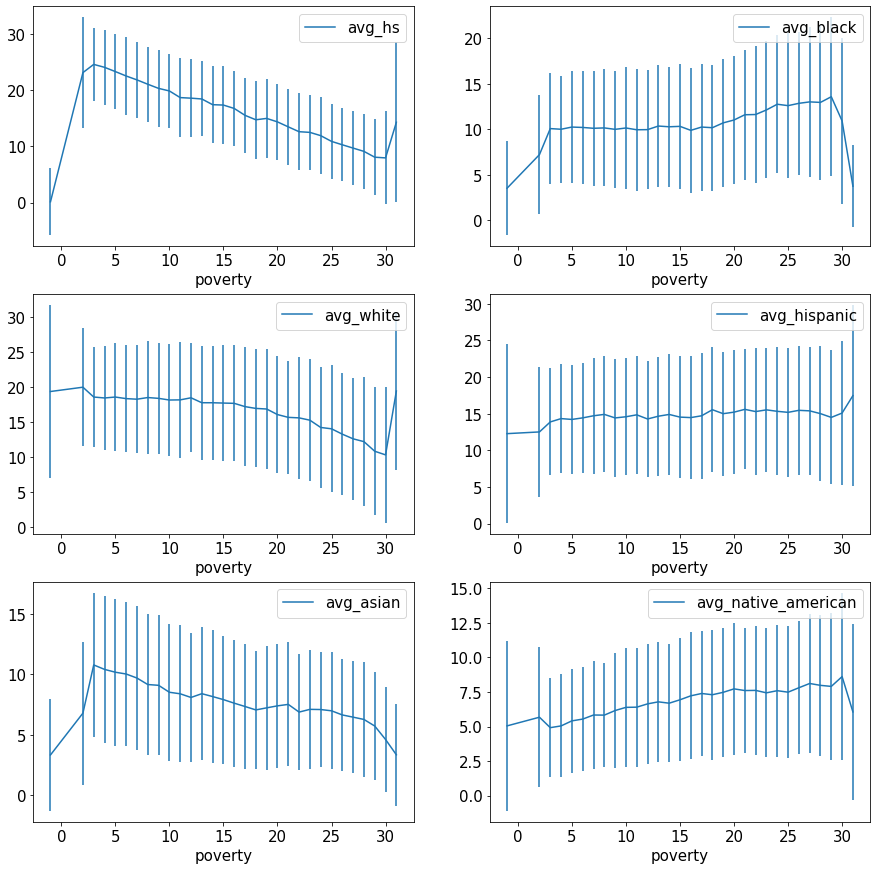

In [29]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(3, 2);
corr_stats('poverty').plot(kind='line', x='poverty', y='avg_hs', yerr='std_hs', ax=axs[0, 0]);
corr_stats('poverty').plot(kind='line', x='poverty', y='avg_black', yerr='std_black', ax=axs[0, 1]);
corr_stats('poverty').plot(kind='line', x='poverty', y='avg_white', yerr='std_white', ax=axs[1, 0]);
corr_stats('poverty').plot(kind='line', x='poverty', y='avg_hispanic', yerr='std_hispanic', ax=axs[1, 1]);
corr_stats('poverty').plot(kind='line', x='poverty', y='avg_asian', yerr='std_asian', ax=axs[2, 0]);
corr_stats('poverty').plot(kind='line', x='poverty', y='avg_native_american', yerr='std_native_american', ax=axs[2, 1]);
fig.savefig('racePoverty.png')
#plt.close(fig)
plt.show()

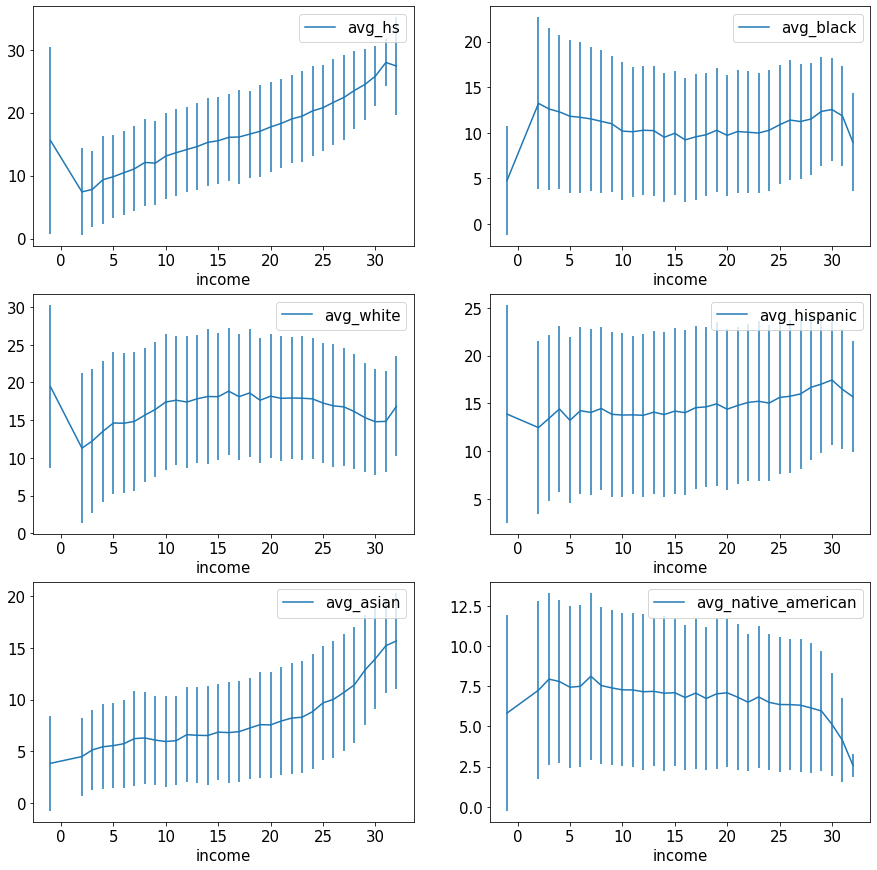

In [36]:
#import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(3, 2);
corr_stats('income').plot(kind='line', x='income', y='avg_hs', yerr='std_hs', ax=axs[0, 0]);
corr_stats('income').plot(kind='line', x='income', y='avg_black', yerr='std_black', ax=axs[0, 1]);
corr_stats('income').plot(kind='line', x='income', y='avg_white', yerr='std_white', ax=axs[1, 0]);
corr_stats('income').plot(kind='line', x='income', y='avg_hispanic', yerr='std_hispanic', ax=axs[1, 1]);
corr_stats('income').plot(kind='line', x='income', y='avg_asian', yerr='std_asian', ax=axs[2, 0]);
corr_stats('income').plot(kind='line', x='income', y='avg_native_american', yerr='std_native_american', ax=axs[2, 1]);
fig.savefig('raceIncome.png')
#plt.close(fig)
plt.show()

Of course, there are many more correlation plots of this kind that we could plot. While ther are some obvious trends, we can see that the standard deviations are large.  I will include some regional varables, such as if a state and thus a city is in the South or in the North-east etc as well as some interaction features.  Keep in mind that these are all just city and state level features and they don't have a time dimension; later, when we look at the police shootings data, from which we will use features and from which we will derive our label (how many police shootings there will be in a given month) we will work with time varying features, which require a whole other set of considerations. I will also minimax scale these features so that they are all between $-1$ and $1$. Throughout I will keep the base_query and use that as a starting point.  

In [42]:
%%bigquery regions_names
SELECT
  DISTINCT region_id,
  region_description,
  states
FROM
  bigquery-public-data.covid19_geotab_mobility_impact_eu.lookup_region
WHERE
  states IS NOT NULL

In [43]:
regions_names

,region_id,region_description,states
0,1,US 1: New England,Connecticut;Maine;Massachusetts;New Hampshire;...
1,2,US 2: NY/NJ,New Jersey;New York;Puerto Rico;US Virgin Islands
2,3,US 3: Mid-Atlantic,Delaware;District of Columbia;Maryland;Pennsyl...
3,4,US 4: South,Alabama;Florida;Georgia;Kentucky;Mississippi;N...
4,5,US 5: Midwest,Illinois;Indiana;Michigan;Minnesota;Ohio;Wisco...
5,6,US 6: Southwest,Arkansas;Louisiana;New Mexico;Oklahoma;Texas
6,7,US 7: Central,Iowa;Kansas;Missouri;Nebraska
7,8,US 8: Rocky Mountain,Colorado;Montana;North Dakota;South Dakota;Uta...
8,9,US 9: West,Arizona;California;Hawaii;Nevada;American Samo...
9,10,US 10: Northwest + AK,Alaska;Idaho;Oregon;Washington


since we don't need the names of hte regions, we only need the region codes, and since the states that belong to the regions aren't abreviated and in a clumsy shape here, we can get the regions from a more convenient source:

In [46]:
%%bigquery regions
SELECT
  DISTINCT region_code as region, state_abbreviation as state, state_name
FROM 
bigquery-public-data.utility_us.us_states_area 
  

In [51]:
regions[regions['region']=='1'] #we can see that the regions are not the same as those in the earlier table

,region,state,state_name
5,1,RI,Rhode Island
6,1,NH,New Hampshire
7,1,VT,Vermont
8,1,CT,Connecticut
9,1,ME,Maine
10,1,MA,Massachusetts
11,1,NJ,New Jersey
12,1,PA,Pennsylvania
13,1,NY,New York


There is a choice as to how we want to partition the US states into regions and this second way to do it is more compelling to me than the first way to partition the states as they seem more natural upon inspection. Another option is to create an embedding space for states, based on what other states are adjacent to each state and this will be my choice, rather than, say one-hot encode each state and then add a one-hot encoded region. 

In [58]:
%%bigquery state_adjacency
SELECT
  state,
  state_fips_code as state_code,
  fips as neighbors
FROM
  `bigquery-public-data.geo_us_boundaries.adjacent_states`,
  UNNEST( neighbors_fips_code ) AS fips


In [59]:
state_adjacency.head()

,state,state_code,neighbors
0,AL,01,12
1,AL,01,13
2,AL,01,28
3,AL,01,47
4,AR,05,47


In [61]:
state_adjacency[state_adjacency['state_code']=='12']

,state,state_code,neighbors
33,FL,12,01
34,FL,12,13


In [62]:
state_adjacency[state_adjacency['state_code']=='13']

,state,state_code,neighbors
35,GA,13,47
36,GA,13,12
37,GA,13,01
38,GA,13,45
39,GA,13,37


what we need, however, is not an adjacency list, but rather and adjacency matrix with columms and rows being the states where there is a 1 whenever two states are next to each other and 0 otherwise. This creates an embedding so that similarly located states are similar to each other in various distance measures. While this could in this case be done using pandas, because there are only 56 states, I will use Apache Beam to do this because this is scalable and because I will in the end use the queries (using BigQuery) as well as Apache Beam to create all of the features in one big pipeline.  Note that so far all of the calculations were done using BigQuery, except for the visualization.  

In [32]:
%%bigquery city_features
SELECT
  *
FROM
  police_brutality.combined_wo_killings


In [33]:
city_features.head()

,State,City,poverty_rate,percent_completed_hs,Median_Income,share_white,share_black,share_native_american,share_asian,share_hispanic
0,AK,Birch Creek CDP,100.0,0.0,NaN,0.0,0.0,100.0,0.0,0.0
1,AK,Ferry CDP,100.0,100.0,NaN,97.0,0.0,0.0,0.0,0.0
2,AZ,Tat Momoli CDP,100.0,0.0,NaN,10.0,0.0,60.0,0.0,30.0
3,AZ,Topock CDP,100.0,100.0,NaN,100.0,0.0,0.0,0.0,0.0
4,AZ,Vaiva Vo CDP,100.0,50.0,NaN,0.0,0.8,97.7,0.0,0.8


In [34]:
city_features.describe()

,poverty_rate,percent_completed_hs,Median_Income,share_white,share_black,share_native_american,share_asian,share_hispanic
count,27823.000000,27827.000000,27241.000000,27999.000000,27999.000000,27999.000000,27999.000000,27999.000000
mean,16.179323,85.945312,51318.858669,83.224390,6.904732,2.785499,1.582496,9.140330
std,12.680797,11.436781,25554.677080,21.553015,15.622831,12.429889,4.353750,17.084784
min,0.000000,0.000000,2500.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.200000,81.300000,35625.000000,78.500000,0.200000,0.100000,0.000000,1.200000
50%,13.600000,88.500000,45304.000000,92.500000,0.800000,0.300000,0.400000,2.900000
75%,22.200000,93.500000,59500.000000,96.900000,4.400000,0.800000,1.200000,8.000000
max,100.000000,100.000000,250000.000000,100.000000,100.000000,100.000000,67.100000,100.000000


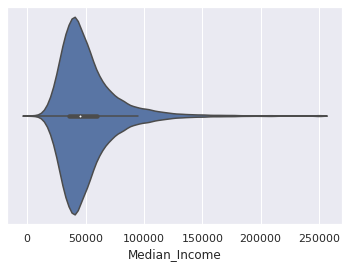

In [37]:
ax = sns.violinplot(data=city_features, x='Median_Income', inner='box', orient='h')

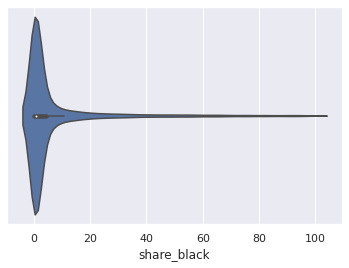

In [38]:
ax = sns.violinplot(data=city_features, x='share_black', inner='box', orient='h')

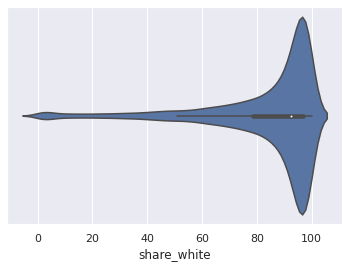

In [39]:
ax = sns.violinplot(data=city_features, x='share_white', inner='box', orient='h')

here we can see that the shares of different ethnicities look quite different 

In [41]:
%%bigquery pop_shares
SELECT
  share_white,
  AVG(share_black) AS share_black,
  STDDEV(share_black) AS std_black
FROM
  police_brutality.combined_wo_killings
GROUP BY
  share_white;

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


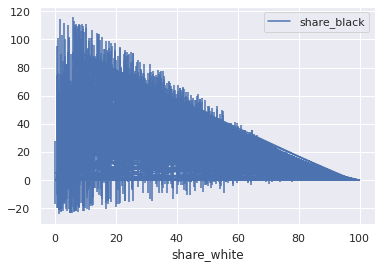

In [42]:
ax = pop_shares.plot(kind='line', x='share_white', y='share_black', yerr='std_black')

we can see here that the standard deviation of the share of black people is a decreasing function of the share of white people

Now I'm going to focus on police shootings

In [43]:
%%bigquery killings
SELECT
  *
FROM
  police_brutality.PoliceKillingsUS

In [44]:
killings.describe()

,id,age
count,2458.000000,2458.000000
mean,1424.458503,36.605370
std,790.000246,13.030774
min,3.000000,6.000000
25%,749.250000,26.000000
50%,1421.500000,34.000000
75%,2096.750000,45.000000
max,2822.000000,91.000000


In [45]:
killings.head()

,id,name,date,manner_of_death,armed,age,gender,race,City,Geographic_Area,signs_of_mental_illness,threat_level,flee,body_camera
0,131,John Martin Whittaker,2008-02-15,shot,gun,33,M,W,Anchorage,AK,False,attack,Car,False
1,836,Tristan Vent,2008-09-15,shot,gun,19,M,N,Fairbanks,AK,False,attack,Not fleeing,False
2,816,Vincent J. Perdue,2009-09-15,shot,gun,33,M,N,Fairbanks,AK,False,attack,Car,False
3,1255,Vincent Nageak,2010-02-16,shot,gun,36,M,N,Barrow,AK,False,attack,Not fleeing,False
4,1305,Patricia Kruger,2021-02-16,shot,gun,38,F,N,Houston,AK,False,attack,Not fleeing,False


In [46]:
killings['body_camera'].unique()

array([False,  True])

In [47]:
killings['flee'].unique()

array(['Car', 'Not fleeing', 'Foot', 'Other', ''], dtype=object)

it looks as though '' is a missing value and here we can likely engineer some interesting features

In [48]:
killings['threat_level'].unique()

array(['attack', 'other', 'undetermined'], dtype=object)

In [121]:
killings['race'].unique()

array(['W', 'N', '', 'B', 'H', 'A', 'O'], dtype=object)

Let's look at this variable via a histogram

In [120]:
alt.Chart(killings).mark_bar(
    cornerRadiusTopLeft=0,
    cornerRadiusTopRight=0
).encode(
    x='Geographic_Area:O',
    y='count():Q',
    color='race:N'
)

alt.Chart(...)

clearly we have to divide the killings by the population of each state from the 2010 census (which I will merge using BigQuery) to normalize this histogram so that we control for the sheer number of people living in a state. We will also have the feature for the shares of ethnicities of course and this shall control for the fact that different states have different proportions of various ethnicities.  For example, if we wanted to know how race biased these shootings are likely to be, we must know how likely an officer is to encounter a person with a given ethnicity.  We would also want this same feature by city rather than by state and I will prepare such a feature, but the resulting histogram is rather large to look at. 

In [129]:
%%bigquery killings
WITH state_pop AS (SELECT
  state_code,
  SUM(cens.population) AS state_pop
FROM
  bigquery-public-data.census_bureau_usa.population_by_zip_2010 AS cens
JOIN
  bigquery-public-data.utility_us.zipcode_area AS code
ON
  code.zipcode=cens.zipcode
  WHERE cens.minimum_age is null AND cens.maximum_age is null AND cens.gender is null
GROUP BY 
  state_code)

SELECT sp.state_code as state, City, name,date,manner_of_death,armed,age,gender,race,signs_of_mental_illness,threat_level,flee,body_camera, sp.state_pop FROM police_brutality.PoliceKillingsUS as k JOIN state_pop as sp ON sp.state_code = k.Geographic_Area

In [134]:
killings[killings['state']=="NY"]

,state,City,name,date,manner_of_death,armed,age,gender,race,signs_of_mental_illness,threat_level,flee,body_camera,state_pop
1551,NY,New City,Vincent Cordaro,2008-02-15,shot,gun,57,M,W,True,attack,Not fleeing,False,19377841
1552,NY,Clarendon,James Ellis,2021-03-15,shot,gun,44,M,W,False,attack,Car,False,19377841
1553,NY,Queens,Jonathan Efraim,2022-04-15,shot,gun,30,M,W,True,attack,Foot,False,19377841
1554,NY,Constantia,David Schwalm,2008-05-15,shot,gun,58,M,W,True,attack,Not fleeing,False,19377841
1555,NY,Queens,Dalton Branch,2026-05-15,shot,gun,51,M,B,False,attack,Not fleeing,False,19377841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1590,NY,Middletown,Richard G. Dinneny,2013-07-16,shot,toy weapon,56,M,W,True,other,Not fleeing,False,19377841
1591,NY,New York,Sergio Reyes,2019-02-17,shot,toy weapon,18,M,H,False,attack,Foot,False,19377841
1592,NY,New York,Jahlire Nicholson,2014-01-17,shot and Tasered,screwdriver,28,M,B,False,attack,Not fleeing,False,19377841
1593,NY,Bronx,Deborah Danner,2018-10-16,shot,baseball bat,66,F,B,True,attack,Not fleeing,False,19377841


As you can see, BigQuery stores a lot of useful data sets in its public data project and can conveniently be pulled in. 

In [150]:
kill_by_eth = killings.groupby(['state', 'race','state_pop']).size().reset_index(name='counts')

In [152]:
kill_by_eth[kill_by_eth['state']=='CA']

,state,race,state_pop,counts
15,CA,,37249542,29
16,CA,A,37249542,14
17,CA,B,37249542,64
18,CA,H,37249542,165
19,CA,N,37249542,1
20,CA,O,37249542,8
21,CA,W,37249542,123


In [168]:
kill_by_eth['normed_pop']=kill_by_eth['state_pop']/min(kill_by_eth['state_pop'].astype(float))

In [171]:
kill_by_eth['count_by_pop']=kill_by_eth['counts']/kill_by_eth['normed_pop']

In [172]:
kill_by_eth

,state,race,state_pop,counts,count_by_pop,normed_pop
0,AK,,709930,1,0.791,1.264
1,AK,B,709930,1,0.791,1.264
2,AK,N,709930,6,4.747,1.264
3,AK,W,709930,7,5.538,1.264
4,AL,,4779588,1,0.118,8.510
...,...,...,...,...,...,...
177,WV,W,1852774,20,6.063,3.299
178,WY,,561662,1,1.000,1.000
179,WY,H,561662,1,1.000,1.000
180,WY,N,561662,1,1.000,1.000


In [173]:
kill_by_eth[kill_by_eth['state']=='CA']

,state,race,state_pop,counts,count_by_pop,normed_pop
15,CA,,37249542,29,0.437,66.320
16,CA,A,37249542,14,0.211,66.320
17,CA,B,37249542,64,0.965,66.320
18,CA,H,37249542,165,2.488,66.320
19,CA,N,37249542,1,0.015,66.320
20,CA,O,37249542,8,0.121,66.320
21,CA,W,37249542,123,1.855,66.320


In [184]:
alt.Chart(kill_by_eth).mark_bar(
    cornerRadiusTopLeft=0,
    cornerRadiusTopRight=0
).encode(
    x='state:O',
    y='count_by_pop:Q',
    color='race:N'
)

alt.Chart(...)

In [185]:
kill_by_eth.describe()

,state_pop,counts,count_by_pop,normed_pop
count,182.000,182.000,182.000,182.000
mean,8002100.159,13.011,1.340,14.247
std,8275048.706,20.465,1.606,14.733
min,561662.000,1.000,0.015,1.000
25%,2865765.750,2.000,0.195,5.102
50%,5301349.000,5.000,0.738,9.439
75%,9687711.000,18.000,1.910,17.248
max,37249542.000,165.000,9.334,66.320


Now we see that this looks quite different; relative to its population size, there aren't as many shootings in California as when compared to its absolute number of shootings. I also divided the population of each state by the population of the smallest state for normalization. Relative to their sizes, we can see that Alaska, New Mexico, Arizona and Oklahoma have a lot of police shootings. We don't yet know the relative biases becaue we haven't yet considered the ethic shares of those states, which will be additional features and we can do interactions with those. 